# Goodreads books recommender system

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from ast import literal_eval
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import math
from scipy.stats import pearsonr


In [2]:
books_df = pd.read_csv('books.csv',converters={"genres": literal_eval})
ratings_df = pd.read_csv('ratings.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# shuffling the test set
np.random.seed(0)
test = test.sample(frac = 1)

## Books

In [ ]:
genres = set(books_df["genres"].explode())
genres

In [ ]:
books_df.info()

In [ ]:
# most rated books
books_df.sort_values('ratings_count', ascending = False)[["title","authors","average_rating", "ratings_count"]].iloc[0:20]

In [ ]:
# authors of top 100 rated books
top_100 = books_df.sort_values(['average_rating'], ascending = False).iloc[0:100,:]

# transform authors to list and get top 15 authors that appear in top 100 books
authors_top_100 = pd.Series([x for item in top_100['authors'] for x in item]).value_counts().to_frame('counts').reset_index()
authors_top_100 = authors_top_100.iloc[0:15,:]

In [ ]:
sns.set_style('darkgrid')
sns.set_palette('cividis')

In [ ]:
ax = sns.histplot(data=books_df, x="average_rating", bins=20)
ax.set_title("Distribution of Book Ratings")
ax.set_xlabel("Average Rating")
ax.set_ylabel("Number of books")
plt.show()

In [ ]:
temp_books = pd.DataFrame()
temp_books["ratings_count_log"]=np.log(books_df.ratings_count)
ax = sns.histplot(data = temp_books, x = "ratings_count_log")
ax.set_title("Distribution of Book Ratings Count")
ax.set_xlabel("Log of number of ratings")
ax.set_ylabel("NUmber of books")
sns.despine()
plt.show()

In [ ]:
ax = sns.scatterplot(data = books_df, x = "ratings_count", y = "average_rating")
ax.set(xlim=(0, 1000000))
ax.set_title("Scatterplot of average book rating vs number of ratings")
ax.set_xlabel("Number of ratings")
ax.set_ylabel("Rating")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{(x/1000000)}M'))
sns.regplot(data=books_df, x="ratings_count", y="average_rating", scatter=False, color='r')

In [ ]:
columns_to_plot = ['average_rating', 'ratings_count']
fig, axes = plt.subplots(ncols=len(columns_to_plot))
for column, axis in zip(columns_to_plot, axes):
    if column == 'ratings_count':
        sns.boxplot(data=books_df[column], ax=axis).set(ylim=(0, 100000))
        axis.set_title('Number of ratings')
    else:
        sns.boxplot(data=books_df[column], ax=axis)
        axis.set_title('Average rating')
plt.tight_layout()
plt.show()

## Ratings

In [ ]:
ratings_df.head()

In [ ]:
ratings_df.info()

In [ ]:
len(ratings_df["book_id"].unique())

In [ ]:
ratings_df[["rating"]].describe()

In [ ]:
ratings_df.groupby('user_id')['book_id'].count().head()

In [ ]:
ax = sns.boxplot(y=ratings_df.groupby('user_id')['book_id'].count(), orient="v")
ax.set_ylim(0, 100)
ax.set_ylabel("Number of ratings")
ax.set_title("Number of ratings by user")

## Naive Baselines

### Global average

In [11]:
mean = train['rating'].mean()

sum = 0
n = 0
for index, row in test.iterrows():
    id = row['book_id']
    sum += (row['rating'] - mean)**2
    n += 1
math.sqrt(sum/n)

1.003925851125348

### Book average

In [8]:
mean = train.groupby('book_id').mean()
book_average_dict = mean['rating'].to_dict()

sum = 0
n = 0
for index, row in test.iterrows():
    id = row['book_id']
    sum += (row['rating'] - book_average_dict[id])**2
    n += 1
math.sqrt(sum/n)

0.9504173082324604

### User average

In [9]:
mean = train.groupby('user_id').mean()
user_average_dict = mean['rating'].to_dict()

sum = 0
n = 0
for index, row in test.iterrows():
    id = row['user_id']
    sum += (row['rating'] - user_average_dict[id])**2
    n += 1
math.sqrt(sum/n)

0.9344274330750967

## Collaborative filtering

We can use the p-value to determine better the similarity between the users.

[4,4], [4,4] has larger similarity than [4,4,4,3,3,4,5], [4,5,4,3,3,4,5], but the second is more preferable.

It is slow as it can be, and it does not work well (:

### Precomputing the data structures

In [12]:
# dictionary from books to list of users which rated the given book
book_user_dict = {}
grouped_data = train.groupby('book_id')
for book_id, group in grouped_data:
    user_generator = (x for x in group['user_id'])
    book_user_dict[book_id] = list(user_generator)
    
# dictionary from users to dictionary of books to rating given by the user
user_book_rating_dict = {}
grouped_data = train.groupby('user_id')
for user_id, group in grouped_data:
    book_rating_dict = {book_id: rating for book_id, rating in zip(group['book_id'], group['rating'])}
    user_book_rating_dict[user_id] = book_rating_dict

### The Algorithm

In [52]:
number_of_books_required = 10
k_neighbours = 10
corr_threshold = 0.5
p_val = True

def user_similarity(r1, r2):
    vals1, vals2 = [], []
    for key in r1:
        if key in r2:
            vals1.append(r1[key])
            vals2.append(r2[key])
    if len(vals1) < number_of_books_required:
        return None
    corr, p = pearsonr(vals1, vals2)
    if (p_val and p > 0.05) or np.isnan(corr) or corr < corr_threshold:
        return None
    return corr

def find_the_similars(user_id, book_id):
    similarities = []
    for user_id2 in book_user_dict[book_id]:
        similarity = user_similarity(user_book_rating_dict[user_id], user_book_rating_dict[user_id2])
        if similarity == None:
            continue
        similarities.append((similarity, user_book_rating_dict[user_id2][book_id], user_id2))
    return sorted(similarities, key=lambda x: x[0], reverse=True)

def predict0(user_id, book_id):
    similarities = find_the_similars(user_id, book_id)
    if len(similarities) < k_neighbours:
        return book_average_dict[book_id], False

    summ = 0
    weights = 0
    for i in range(k_neighbours):
        sim = similarities[i][0]
        summ += similarities[i][1] * sim
        weights += sim
    
    return summ / weights, True

def predict1(user_id, book_id):
    similarities = find_the_similars(user_id, book_id)
    if len(similarities) < k_neighbours:
        return book_average_dict[book_id], False

    summ = 0
    weights = 0
    for i in range(k_neighbours):
        sim = similarities[i][0]
        summ += (similarities[i][1]-book_average_dict[book_id]) * sim
        weights += sim
    
    return book_average_dict[book_id]+(summ / weights), True

def predict2(user_id, book_id):
    similarities = find_the_similars(user_id, book_id)
    if len(similarities) < k_neighbours:
        return user_average_dict[user_id], False

    summ = 0
    weights = 0
    for i in range(k_neighbours):
        sim = similarities[i][0]
        score = similarities[i][1]
        user2 = similarities[i][2]
        summ += sim * (score-user_average_dict[user2]) 
        weights += sim
    
    return user_average_dict[user_id]+(summ / weights), True

### Testing

In [53]:
%%time
# n is a counter so I can stop it early
n = 0 
s = 0
successful = 0
for _, row in test.iterrows():
    predicted, ok = predict0(row['user_id'], row['book_id'])
    # predicted, ok = predict1(row['user_id'], row['book_id'])
    # predicted, ok = predict2(row['user_id'], row['book_id'])
    if ok:
       successful += 1 
    s += (row['rating']-predicted)  ** 2
    n += 1
    if n % 10000 == 0:
        print(math.sqrt(s/n), n, successful)
print(math.sqrt(s/n), n, successful)

0.9559829226196143 10000 2706
0.9561919567762762 20000 5402
0.9572422274389772 30000 8089
0.9573576060890804 40000 10745
0.9593550616904334 50000 13497
0.9618514644769878 60000 16236
0.9618654277470622 70000 18910
0.9622182635957338 80000 21650
0.9629295014584806 90000 24365
0.9622640695565708 100000 27115
0.9621529876237165 110000 29770
0.9622405932881856 120000 32454
0.9612800007123308 130000 35173
0.9613144421637557 140000 37922
0.961366684181615 150000 40682
0.9608300737113401 160000 43464
0.9611095402160819 170000 46225
0.9612227410069734 180000 49011
0.9610126106629111 190000 51774
0.960927266831918 200000 54517
0.9608693418905657 210000 57240
0.9609436439983681 214325 58454
CPU times: user 27min 44s, sys: 584 ms, total: 27min 45s
Wall time: 27min 44s


### Graphing

In [59]:
# harry potter book
# TODO graph the values of similarities
find_the_similars('eb17c61f4ad60a6edd23b30af3cf9aec', 3)
'eb17c61f4ad60a6edd23b30af3cf9aec'
'a759dbe40b97ae6508237f2ef2efcdf6'

In [63]:
dict1 = user_book_rating_dict['eb17c61f4ad60a6edd23b30af3cf9aec']
dict2 = user_book_rating_dict['a759dbe40b97ae6508237f2ef2efcdf6']
vals1 = []
vals2 = []
book_ids = []
for key in dict1.keys():
    if key in dict2:
        vals1.append(dict1[key])
        vals2.append(dict2[key])
        book_ids.append(key)
book_names = books_df.loc[books_df['book_id'].isin(book_ids), 'title'].tolist()

In [74]:
data = {'user1': vals1,
        'user2': vals2,
        'book_names': book_names}

correlation_sample_df = pd.DataFrame(data)

In [76]:
correlation_sample_df

,user1,user2,book_names
0,4,5,Harry Potter and the Sorcerer's Stone (Harry P...
1,5,5,Harry Potter and the Prisoner of Azkaban (Harr...
2,5,5,Harry Potter and the Order of the Phoenix (Har...
3,1,1,Harry Potter and the Chamber of Secrets (Harry...
4,4,5,Harry Potter and the Goblet of Fire (Harry Pot...
5,5,5,Harry Potter and the Deathly Hallows (Harry Po...
6,5,5,"A Game of Thrones (A Song of Ice and Fire, #1)"
7,5,5,Jane Eyre
8,4,5,The Handmaid's Tale
9,5,5,Robinson Crusoe


In [19]:
real_list = []
baseline_list1 = []
predicted_list1 = []
baseline_list2 = []
predicted_list2 = []

stop_after = 1000
for _, row in test.iterrows():
    user_id, book_id = row['user_id'], row['book_id']
    real_list.append(row['rating'])
    predicted_list1.append(predict1(user_id, book_id)[0])
    predicted_list2.append(predict2(user_id, book_id)[0])
    baseline_list1.append(book_average_dict[book_id])
    baseline_list2.append(user_average_dict[user_id])
    stop_after -= 1
    if stop_after == 0:
        break


In [30]:
measurements = pd.DataFrame(list(zip(real_list, baseline_list1, baseline_list2, predicted_list1, predicted_list2)), columns =['real', 'baseline1', 'baseline2', 'predicted1', 'predicted2'])

<AxesSubplot:xlabel='baseline1', ylabel='predicted1'>

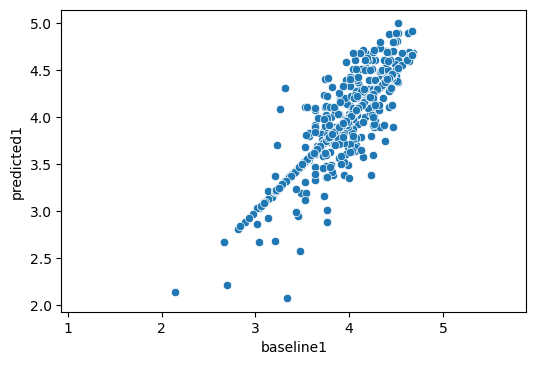

In [39]:
plt.axis('equal')
sns.scatterplot(data=measurements, x='baseline1', y="predicted1")

<AxesSubplot:xlabel='baseline2', ylabel='predicted2'>

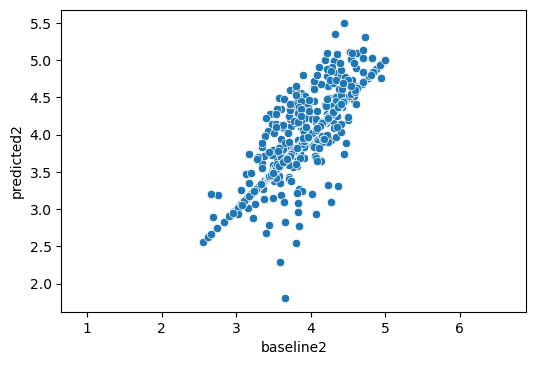

In [46]:
plt.axis('equal')
sns.scatterplot(data=measurements, x='baseline2', y="predicted2")

<AxesSubplot:xlabel='predicted1', ylabel='real'>

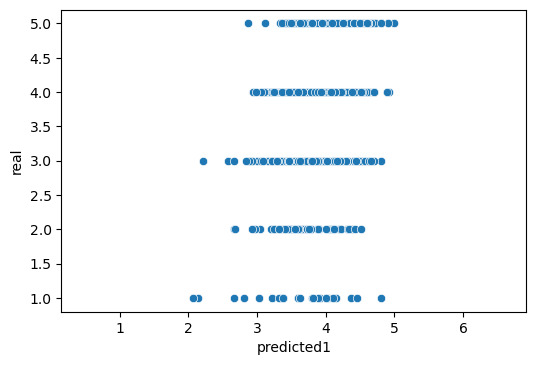

In [42]:
plt.axis('equal')
sns.scatterplot(data=measurements, x='predicted1', y="real")

<AxesSubplot:xlabel='predicted2', ylabel='real'>

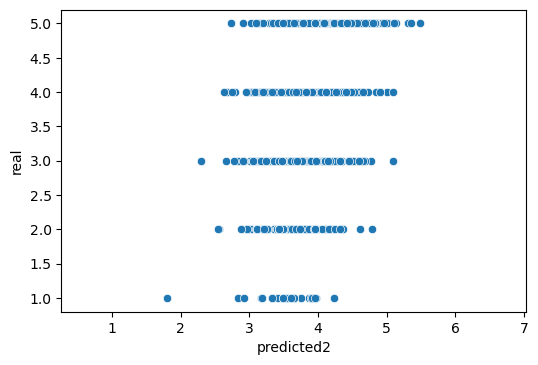

In [43]:
plt.axis('equal')
sns.scatterplot(data=measurements, x='predicted2', y="real")

<AxesSubplot:xlabel='predicted1', ylabel='predicted2'>

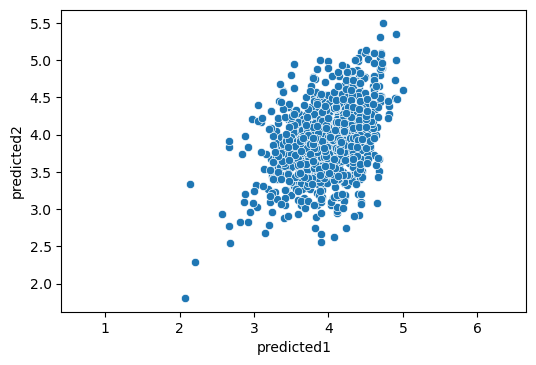

In [45]:
plt.axis('equal')
sns.scatterplot(data=measurements, x='predicted1', y="predicted2")